In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
import statsmodels.api as sm

from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
df = pd.read_csv('QUARTERLY.csv')

In [4]:
def correlation_plot(data, lags=40):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

In [6]:
df.columns

Index(['Unnamed: 0', 'ffr', 'tbill', 'tb1yr', 'r5', 'r10', 'ppinsa',
       'finished', 'cpi', 'cpicore', 'm1nsa', 'm2sa', 'm2nsa', 'unemp',
       'indprod', 'rgpdp', 'potent', 'deflator', 'curr'],
      dtype='object')

In [10]:
df.head()

,Unnamed: 0,ffr,tbill,tb1yr,r5,r10,ppinsa,finished,cpi,cpicore,m1nsa,m2sa,m2nsa,unemp,indprod,rgpdp,potent,deflator,curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.8
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.9
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.2
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.6
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.1


In [62]:
y = df['unemp'].dropna()

<AxesSubplot:>

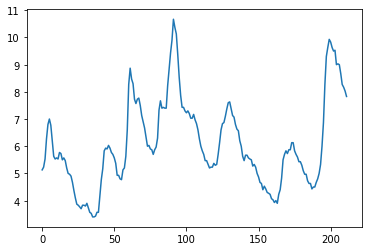

In [64]:
df['unemp'].plot()

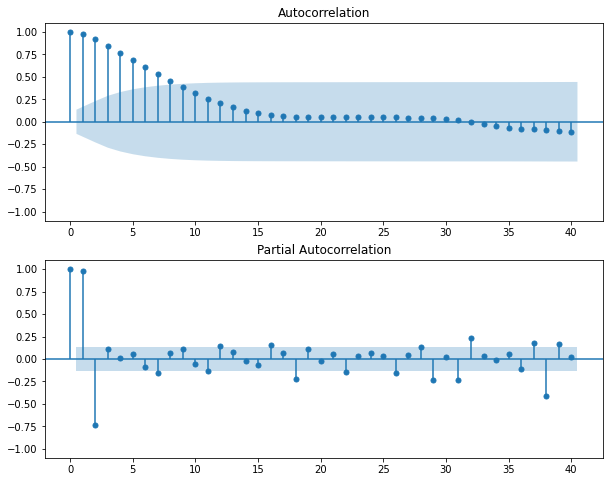

In [63]:
correlation_plot(y)

---ctt---
(-2.700307553666679, 0.4541294246242923, 9, 202, {'1%': -4.429415685178409, '5%': -3.8619465867159213, '10%': -3.5715142605753076}, 14.342734928674645)
---ct---
(-2.7107507139443627, 0.23164591715240807, 9, 202, {'1%': -4.004300299325148, '5%': -3.432451607287579, '10%': -3.139948906775787}, 12.582816292142525)
---c---
(-2.597747221312522, 0.09346376545524082, 9, 202, {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}, 11.39043844213802)
---nc---
(0.05972477514940414, 0.7037905728736606, 12, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, 13.888856100769772)


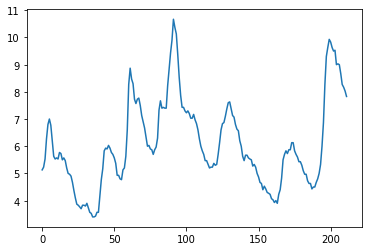

In [66]:
# 単位根過程であるかを検定。単位根過程（＝非定常過程）だとARを適用できない。
# p値が大きいと、単位根過程であることを棄却できない。すなわち、定常状態ではないと判断する。
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

In [67]:
# 考えられるパラメータの組み合わせを全て作成
max_p = 2 #AR(自己回帰過程)の次数：いくつ前までの数字を回帰させるか
max_d = 1 #I（和分過程）の次数：原系列に対して何回差分を取るか
max_q = 1 #MA（移動平均過程）の次数：いくつ前までのノイズを回帰させるか
params = []

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            params.append([p,d,q])

len(params)

12

In [68]:
# MAPEを計算する自作関数を定義
def calc_mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

In [69]:
# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(endog=y, trend="n", order=(param[0], param[1], param[2]), 
                                enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df = aic_df.reset_index(drop=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    3.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.5s finished


,params,aic
0,"[2, 1, 1]",23.837184
1,"[1, 1, 0]",23.837793
2,"[2, 1, 0]",24.885100
3,"[1, 1, 1]",24.964485
4,"[2, 0, 0]",25.376715
5,"[2, 0, 1]",26.579965
6,"[0, 1, 1]",52.283882
7,"[1, 0, 1]",54.712751
8,"[0, 1, 0]",142.958049
9,"[1, 0, 0]",144.683188


In [86]:
# AICが最小のパラメータを当てはめる
param = [2,1,1]

model = sm.tsa.statespace.SARIMAX(endog=y, trend="c", order=(param[0], param[1], param[2]), 
                                enforce_invertibility = False, enforce_stationarity = False)
results = model.fit()

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  unemp   No. Observations:                  212
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  -7.915
Date:                Sun, 11 Apr 2021   AIC                             25.831
Time:                        17:49:28   BIC                             42.543
Sample:                             0   HQIC                            32.588
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.009      0.061      0.951      -0.017       0.018
ar.L1          1.3065      0.242      5.397      0.000       0.832       1.781
ar.L2         -0.4829      0.161     -2.997      0.003      -0.799      -0.167
ma.L1         -0.5955      0.251     -2.375      0.018      -1.087      -0.104
sigma2         0.0630      0.005     12.484      0.000       0.053       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                58.32
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.69
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
y_pred = results.predict()

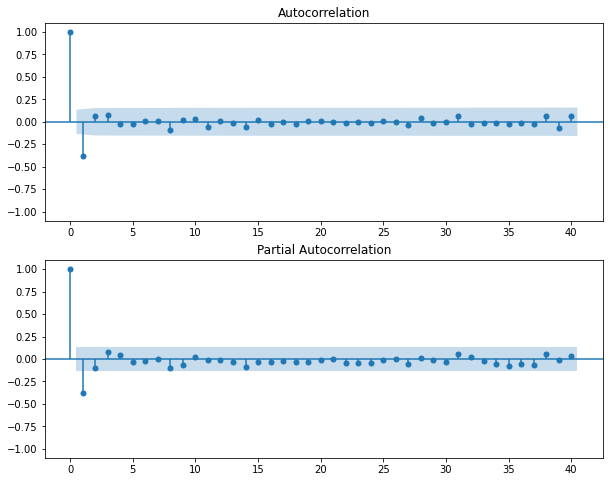

1 31.407358393436613 2.0918661192174406e-08
2 32.17163059898189 1.0328070136829723e-07
3 33.382568259590016 2.674466427674678e-07
4 33.520234294093434 9.345863486714638e-07
5 33.71255105243962 2.7162167552986298e-06
6 33.739300403096955 7.553774732767332e-06
7 33.741286001426396 1.925463615300642e-05
8 35.44546157565785 2.2177077418783093e-05
9 35.51352708422251 4.835083265032384e-05
10 35.731012028854636 9.36205619062822e-05


/home/rnomura/.cache/pypoetry/virtualenvs/timeseries-KrZpyNEk-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [89]:
diff_arr = y_pred - y
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1